# Telecom Churn Prediction Case Study

We will be going over the case study in below steps
1. Study Business Problem
2. Data Operations:<br>
    a. Load<br>
    b. Understanding<br>
    c. Cleaning<br>
3. Exploratory Data Analysis
4. Data Preparation & Preprocessing<br>
    a. Train Test data split<br>
    b. Handle missing data<br>
    c. Scalability<br>
    d. Derived and Dummy Variable preparation<br>
5. Feature Engineering using PCA
6. Model Building:<br>
    a. SVM<br>
    b. Logistic Regression<br>
    c. Random Forest or Decision Tree<br>
    d. XGBoost<br>
7. Model Evaluation using following metrics:<br>
    a. Accuracy<br>
    b. Confusion Metrics<br>
    c. Precision<br>
    d. Recall<br>
    e. F1 Score<br>
8. Model Selection based on accuracy metric
9. Predictions for test dataset

## 1. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

## 2: Data Operations

### 2.a. Loading dependencies & datasets

In [84]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

#pip install missingno## For installing missingno library, type this command in terminal


import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option("display.max_columns",200)

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [85]:
# Load data files and data dictionary 

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


### 2.b: Data Understanding

1. Analyze the data dictionary versus the churn dataset.
2. Data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents

In [86]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [87]:
# Get length of total available columns
len(data.columns)

172

In [88]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

Let's look at each variable's datatype:

In [89]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

Let's also summarize the features using the df.describe method:

In [90]:
data.describe(include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,68898,68765,67538,69999.000000,69999.000000

Based on column sparsity and nature of data, selecting few columns

Example: 
- circle_id -> Static through out hence dropping
- arpu_2g/3g-> These can be studied based on total arpu as well, hence dropping specific fields <br>
Performing same for other fields as well

In [91]:
ids = ['id']

# Accumulate the data for all three months (6,7,8)
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
total_incoming_minutes = [i for i in list(data.columns) if re.search('total.+ic.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]
average_revenue = [i for i in list(data.columns) if re.search('arpu_',i)]
onnet = [i for i in list(data.columns) if re.search('onnet_',i)]
total_rech_data = [i for i in list(data.columns) if re.search('total_rech_data',i)]
total_rech_num = [i for i in list(data.columns) if re.search('total_rech_num',i)]
last_day_rch_amt = [i for i in list(data.columns) if re.search('last_day_rch_amt',i)]
night_pck_user = [i for i in list(data.columns) if re.search('night_pck_user',i)]
max_rech_amt = [i for i in list(data.columns) if re.search('max_rech_amt',i)]
max_rech_data = [i for i in list(data.columns) if re.search('max_rech_data',i)]
av_rech_amt_data = [i for i in list(data.columns) if re.search('av_rech_amt_data',i)]
volume_based_cost = [i for i in list(data.columns) if re.search('vbc',i)]

target_variable = ["churn_probability"]
#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *total_incoming_minutes,
             *offnetwork_minutes, 
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             *average_revenue,
             *onnet,
             *total_rech_data,
             *total_rech_num,
             *last_day_rch_amt,
             *night_pck_user,
             *max_rech_amt,
             *max_rech_data,
             *av_rech_amt_data,
             *volume_based_cost,
             *target_variable]

data_telecom = data[variables].set_index('id')

In [92]:
len(data_telecom.columns)

56

### 2.c Data Cleaning

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

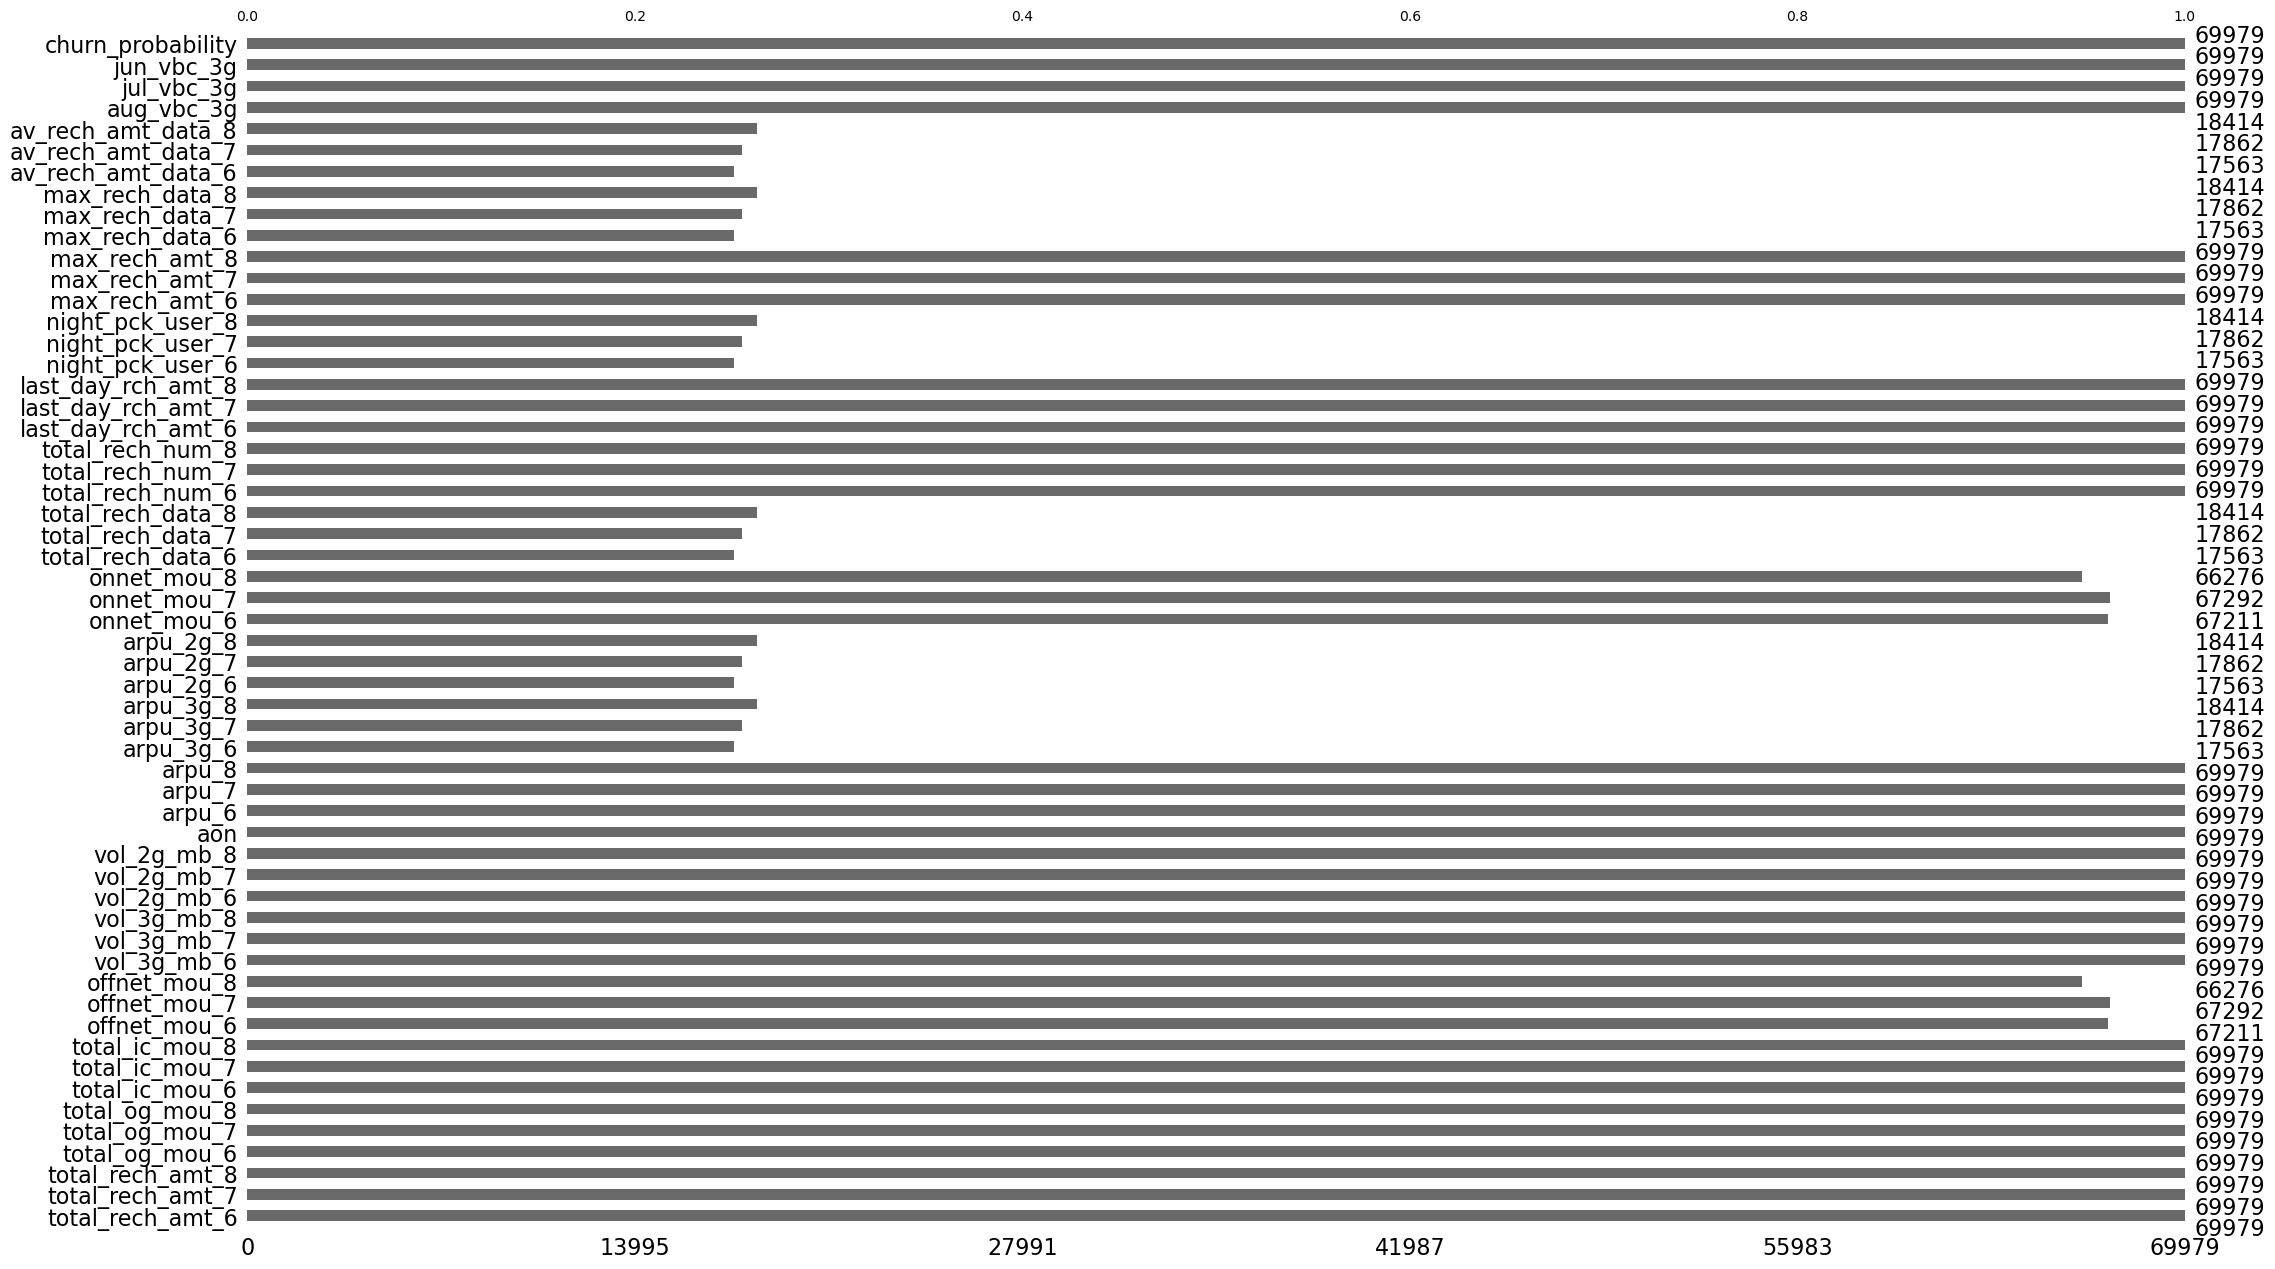

In [93]:
msno.bar(data_telecom[20:])

<Axes: >

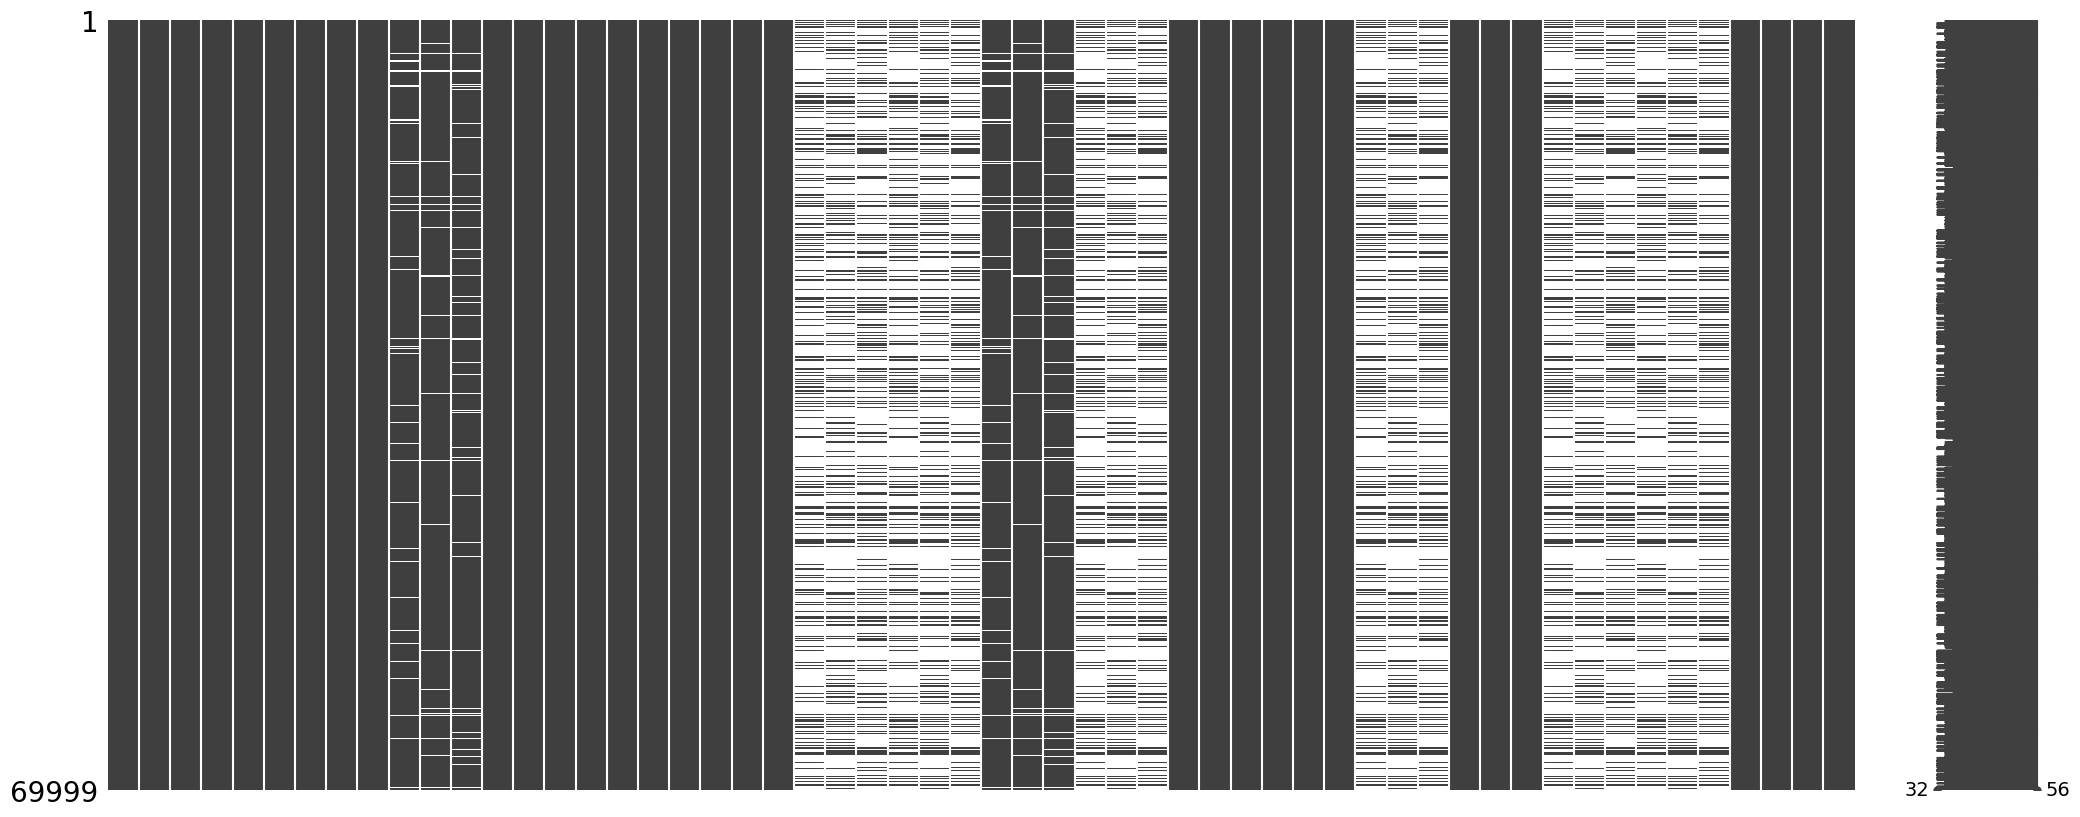

In [94]:
msno.matrix(data_telecom)

Lets also calculate the % missing data for each column:

In [95]:
data_msd = data_telecom.reset_index()
missing_data_percent = 100*data_msd.isnull().sum()/len(data_msd[target_variable])
missing_data_percent.sort_values(ascending=False)

total_rech_data_6     74.902499
arpu_2g_6             74.902499
av_rech_amt_data_6    74.902499
arpu_3g_6             74.902499
night_pck_user_6      74.902499
max_rech_data_6       74.902499
night_pck_user_7      74.478207
total_rech_data_7     74.478207
arpu_2g_7             74.478207
av_rech_amt_data_7    74.478207
max_rech_data_7       74.478207
arpu_3g_7             74.478207
arpu_2g_8             73.689624
arpu_3g_8             73.689624
night_pck_user_8      73.689624
max_rech_data_8       73.689624
av_rech_amt_data_8    73.689624
total_rech_data_8     73.689624
onnet_mou_8            5.290076
offnet_mou_8           5.290076
offnet_mou_6           3.954342
onnet_mou_6            3.954342
offnet_mou_7           3.838626
onnet_mou_7            3.838626
max_rech_amt_8         0.000000
total_rech_num_8       0.000000
jun_vbc_3g             0.000000
jul_vbc_3g             0.000000
total_rech_num_7       0.000000
aug_vbc_3g             0.000000
max_rech_amt_6         0.000000
last_day

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 70% missing data.

In [96]:
new_vars = missing_data_percent[missing_data_percent.le(70)].index
data_telecom= data_msd[new_vars]

In [97]:
data_telecom.head()

,id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,77,65,10,81.21,221.68,3.63,11.84,53.04,40.56,32.24,96.68,2.33,0.0,0.00,0.0,0.0,0.00,0.00,1958,31.277,87.009,7.527,48.58,124.38,1.29,3,2,2,65,65,0,65,65,10,0.0,0.0,0.0,0
1,1,0,145,50,0.00,30.73,31.66,3.44,39.44,25.04,0.00,25.99,30.89,0.0,3.96,0.0,0.0,352.91,0.00,710,0.000,122.787,42.953,0.00,0.00,0.00,3,4,5,0,0,0,0,145,50,0.0,0.0,0.0,0
2,2,70,120,0,56.49,99.36,0.00,124.29,33.83,36.64,53.99,82.05,0.00,0.0,0.00,0.0,0.0,0.00,0.00,882,60.806,103.176,0.000,0.53,15.93,0.00,2,4,2,70,50,0,70,70,0,0.0,0.0,0.0,0
3,3,160,240,130,76.03,95.98,53.84,95.11,50.18,83.84,68.76,78.48,50.23,0.0,0.00,0.0,0.0,0.00,0.00,982,156.362,205.260,111.095,7.26,16.01,0.00,2,4,3,110,110,50,110,110,50,0.0,0.0,0.0,0
4,4,290,136,122,63.26,42.94,15.76,21.54,9.36,28.31,56.99,38.11,9.63,0.0,0.00,0.0,390.8,308.89,213.47,647,240.708,128.191,101.565,21.28,4.83,6.13,13,10,8,25,10,30,50,41,30,0.0,0.0,0.0,0


From 172, we have reduced column count to 39, lets see statistics for these fields before proceeding for EDA

In [98]:
data_telecom.describe()

,id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,199.710640,201.878029,198.486034,198.874771,197.153383,196.543577,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,7.566522,7.706667,7.224932,63.426949,59.294218,62.489478,104.569265,104.137573,107.540351,68.108597,65.935830,60.07674,0.101887
std,20207.115084,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,290.114823,296.771338,288.336731,316.818355,322.482226,324.089234,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,7.041452,7.050614,7.195597,97.954876,95.429492,101.996729,121.407701,120.782543,124.396750,269.328659,267.899034,257.22681,0.302502
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,38.640000,41.340000,38.290000,34.860000,32.240000,31.575000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,30.000000,30.000000,30.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,114.780000,116.330000,114.610000,96.480000,91.885000,91.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,6.000000,6.000000,5.000000,30.000000,30.000000,30.000000,110.000000,110.000000,98.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,251.070000,249.470000,249.710000,232.990000,227.630000,229.345000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,9.000000,10.000000,9.000000,110.000000,110.000000,130.000000,120.000000,128.000000,144.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,7716.140000,9699.010000,10830.380000,8362.360000,7043.980000,14007.340000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,170.000000,138.000000,138.000000,4010.000000,3100.000000,4449.000000,4010.000000,3299.000000,4449.000000,12916.220000,9165.600000,11166.21000,1.000000


<Axes: >

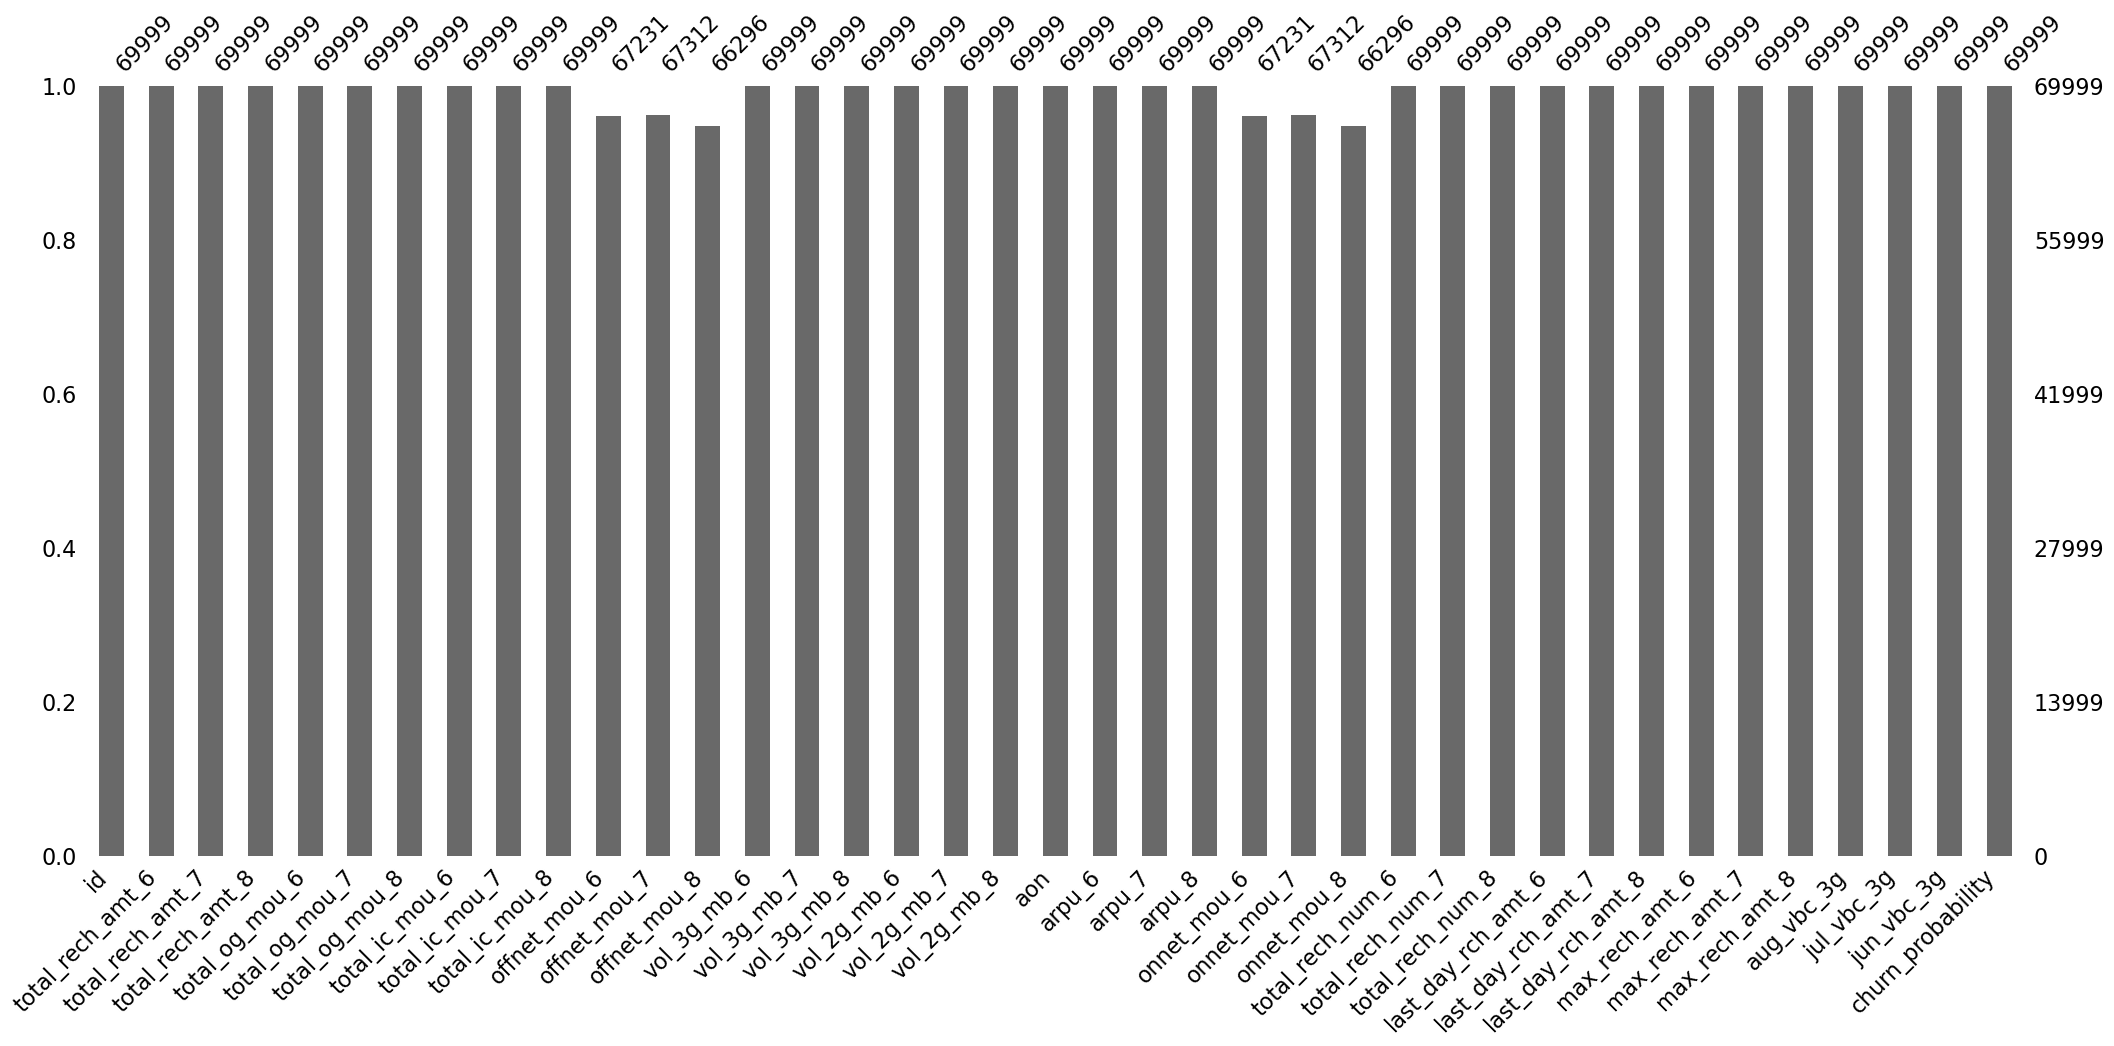

In [99]:
msno.bar(data_telecom)

##### Handling Missing data

Next, we try imputation on variables with any amount of missing data still left.

In [100]:
missing_data_percent = data_telecom.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8'],
      dtype='object')

Using simple imputation with constant values as zeros as these are outgoing minutes

In [101]:
imp = SimpleImputer(strategy='constant', fill_value=0)
data_telecom[impute_cols] = imp.fit_transform(data_telecom[impute_cols])

<Axes: >

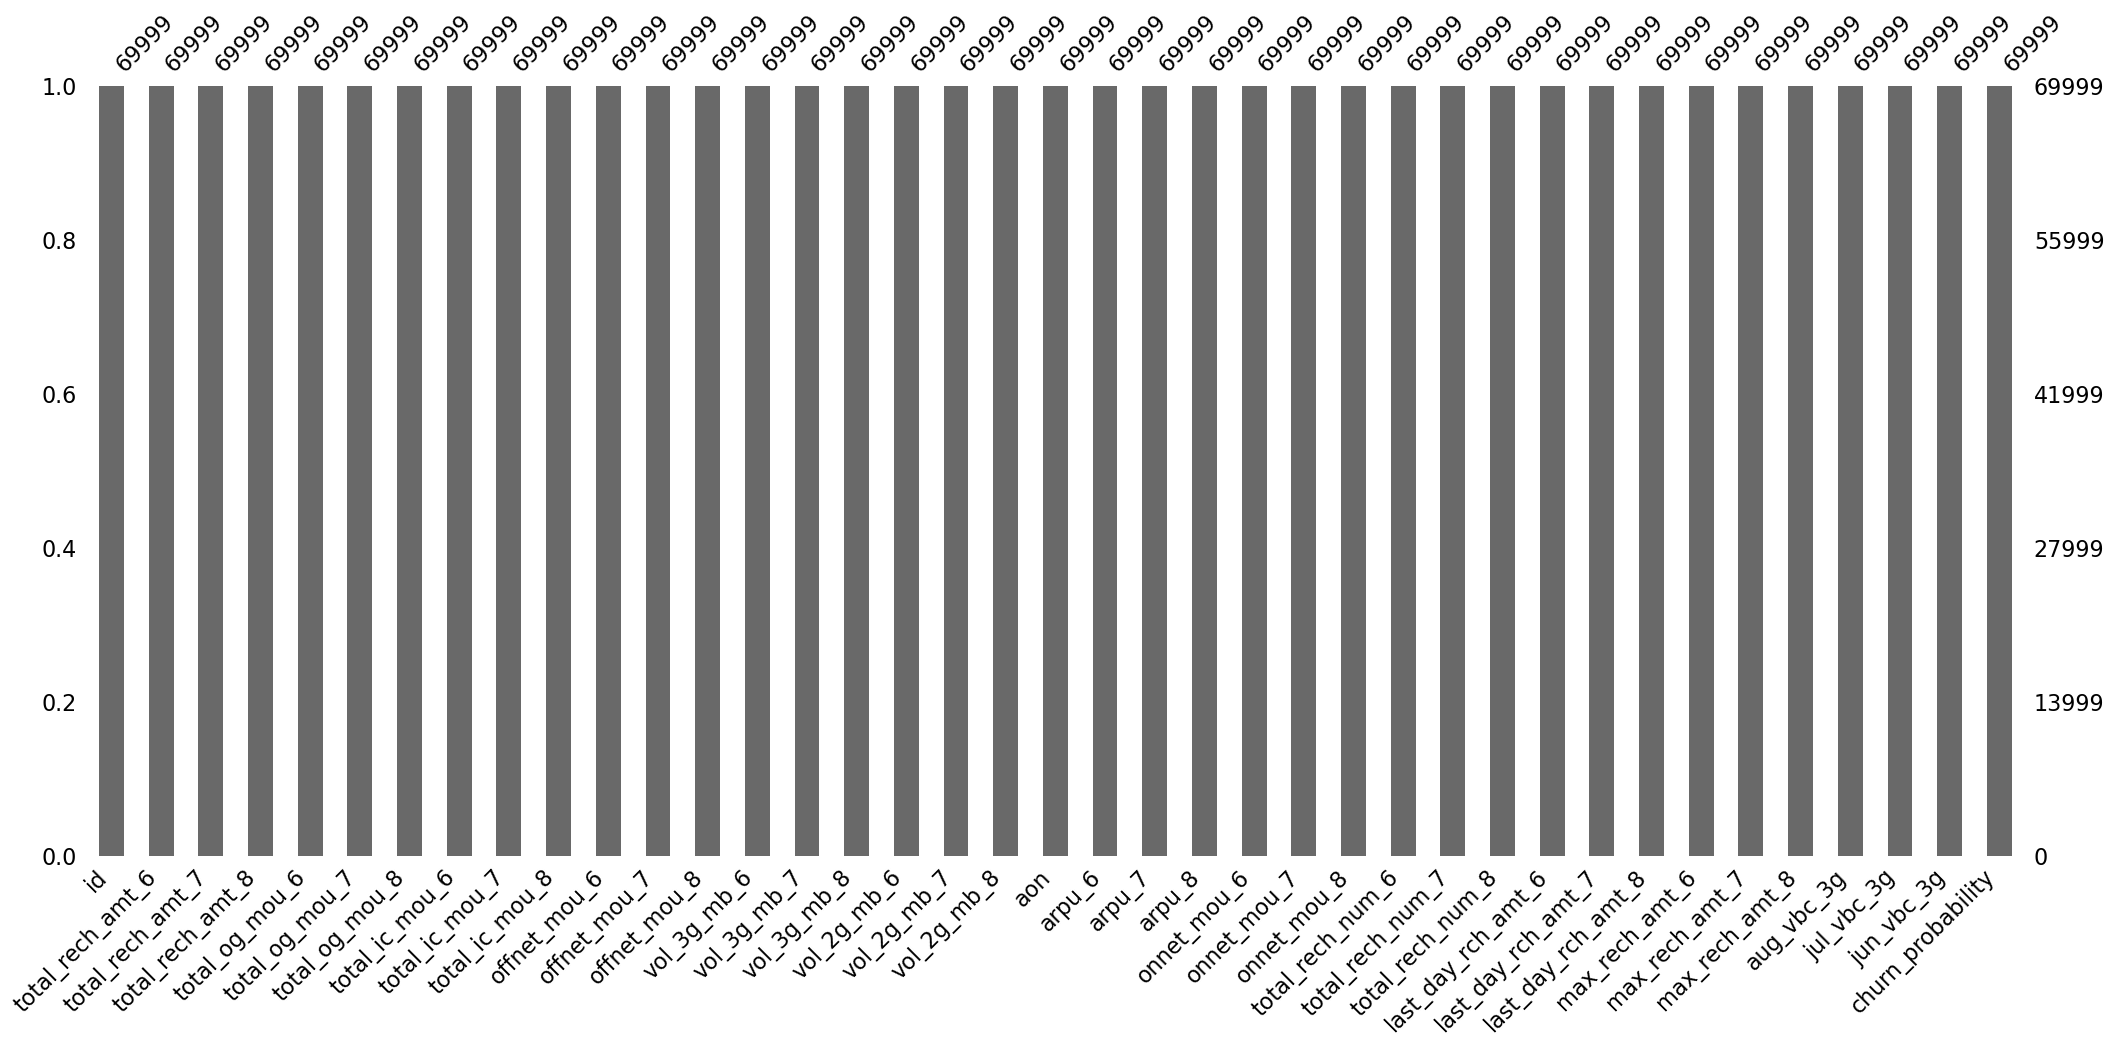

In [102]:
msno.bar(data_telecom)

In [103]:
data_telecom.describe()

,id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,199.710640,201.878029,198.486034,191.010582,189.585401,186.146273,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,283.134365,278.185912,278.858826,127.887939,128.754731,125.943607,7.566522,7.706667,7.224932,63.426949,59.294218,62.489478,104.569265,104.137573,107.540351,68.108597,65.935830,60.07674,0.101887
std,20207.115084,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,290.114823,296.771338,288.336731,312.900706,318.492632,318.453812,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,334.213918,344.366927,351.924315,295.115497,306.326345,304.990552,7.041452,7.050614,7.195597,97.954876,95.429492,101.996729,121.407701,120.782543,124.396750,269.328659,267.899034,257.22681,0.302502
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,38.640000,41.340000,38.290000,28.790000,26.690000,23.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,93.581000,86.714000,84.095000,5.430000,4.910000,4.110000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,30.000000,30.000000,30.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,114.780000,116.330000,114.610000,89.810000,85.590000,83.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,197.484000,191.588000,192.234000,30.830000,29.160000,27.840000,6.000000,6.000000,5.000000,30.000000,30.000000,30.000000,110.000000,110.000000,98.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,251.070000,249.470000,249.710000,223.540000,218.350000,216.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,370.791000,365.369500,369.909000,113.100000,108.940000,106.280000,9.000000,10.000000,9.000000,110.000000,110.000000,130.000000,120.000000,128.000000,144.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,7716.140000,9699.010000,10830.380000,8362.360000,7043.980000,14007.340000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,170.000000,138.000000,138.000000,4010.000000,3100.000000,4449.000000,4010.000000,3299.000000,4449.000000,12916.220000,9165.600000,11166.21000,1.000000


No missing data is left, we can proceed with data analysis now

In [104]:
data_telecom.set_index("id", inplace=True)

In [105]:
variables=data_telecom.columns.to_list()
variables.remove(target_variable[0])

In [106]:
#Creating X and y variables
X = data_telecom[variables]
y = data_telecom[target_variable]

Filter high-value customers


In [187]:
data_telecom['avg_rech_amt_6_7'] = (data_telecom['total_rech_amt_6'] + data_telecom['total_rech_amt_7'])/2



In [188]:
rech_70percentile = data_telecom['avg_rech_amt_6_7'].quantile(0.7)
data_telecom = data_telecom[data_telecom['avg_rech_amt_6_7'] >= rech_70percentile]
data_telecom.head()

,jun_vbc_3g,total_rech_num_7,max_rech_amt_6,total_rech_amt_8,vol_2g_mb_6,vol_3g_mb_7,total_ic_mou_7,vol_3g_mb_6,total_rech_num_8,jul_vbc_3g,last_day_rch_amt_6,max_rech_amt_7,max_rech_amt_8,aug_vbc_3g,total_og_mou_6,total_og_mou_7,vol_3g_mb_8,vol_2g_mb_7,vol_2g_mb_8,last_day_rch_amt_7,total_rech_amt_6,aon,last_day_rch_amt_8,total_rech_amt_7,total_og_mou_8,total_rech_num_6,churn_probability,total_rech_amt,avg_rech_amt_6_7
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,0.0,10.0,110.0,365.0,0.00,0.0,35.34,0.0,20.0,0.0,110.0,110.0,50.0,0.0,816.44,836.23,0.0,0.0,0.00,0.0,521.0,322.0,0.0,418.0,687.41,15.0,0,1304.0,469.5
15,0.0,3.0,250.0,652.0,260.42,0.0,777.39,0.0,4.0,0.0,0.0,250.0,250.0,0.0,327.64,366.79,0.0,0.0,354.35,150.0,654.0,602.0,250.0,400.0,391.53,5.0,0,1706.0,527.0
23,0.0,19.0,110.0,494.0,0.00,0.0,448.36,0.0,10.0,0.0,110.0,110.0,144.0,0.0,1152.99,822.83,0.0,0.0,0.00,50.0,1420.0,455.0,30.0,990.0,387.81,26.0,0,2904.0,1205.0
24,0.0,7.0,110.0,240.0,0.04,0.0,155.64,0.0,10.0,0.0,110.0,110.0,30.0,0.0,624.38,546.06,0.0,0.0,0.00,0.0,440.0,1219.0,30.0,427.0,251.89,7.0,0,1107.0,433.5
25,0.0,5.0,110.0,730.0,0.00,0.0,319.08,0.0,11.0,0.0,110.0,150.0,130.0,0.0,616.93,309.41,0.0,0.0,0.00,150.0,330.0,2831.0,50.0,480.0,754.16,8.0,0,1540.0,405.0


In [189]:
data_telecom.shape

(21018, 29)

## 3. EDA

#### 3.a Univariate Analysis

<Axes: >

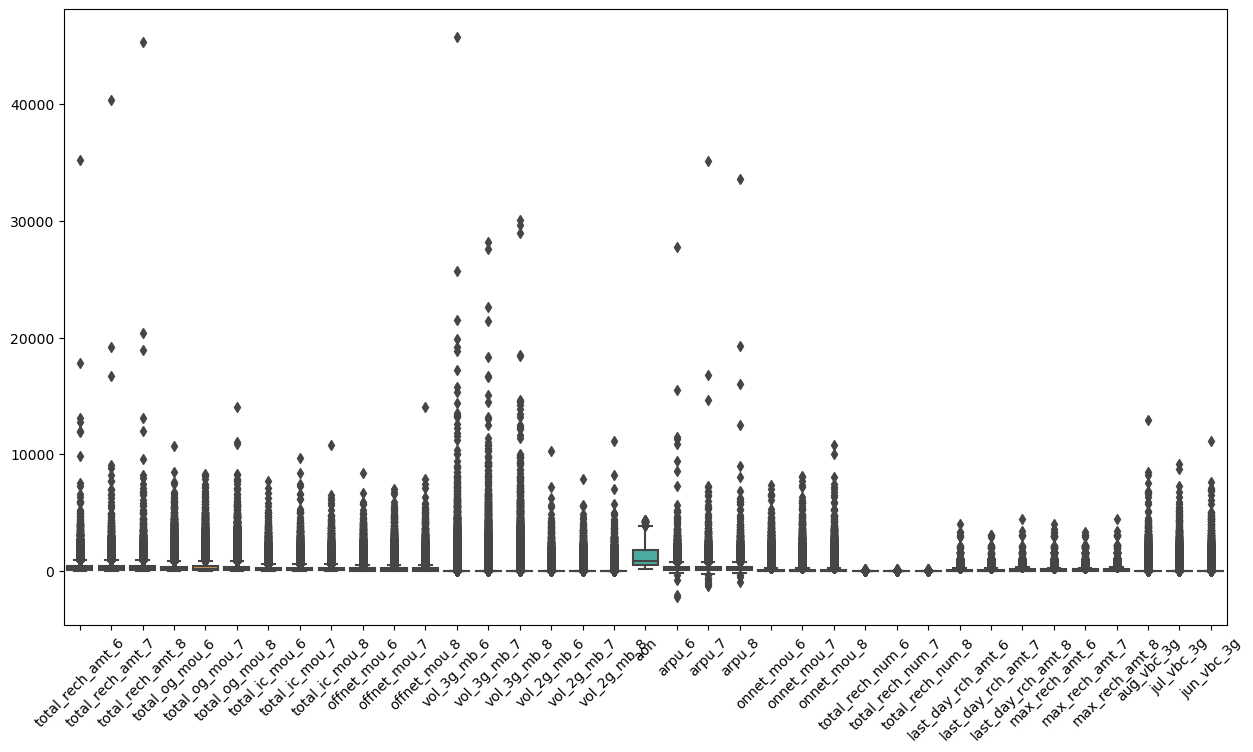

In [107]:
# Distribution of all variables
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X)

##### Handling outliers

The box plots of features show there are a lot of outliers. These can be capped with k-sigma method.

<Axes: >

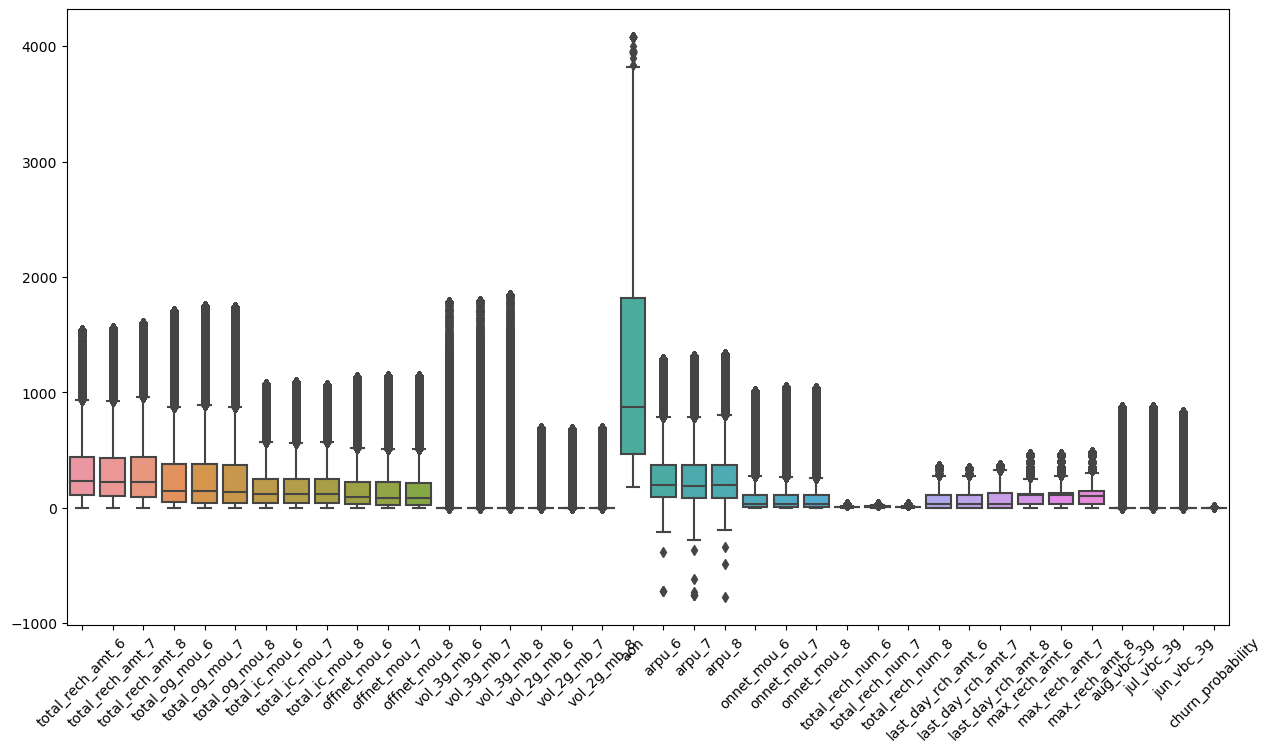

In [108]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

data_telecom[variables] = data_telecom[variables].apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = data_telecom)

##### Bivariate and Multivariate analysis

In [109]:
c = pd.DataFrame(data_telecom, columns=variables).corr()

In [110]:
c

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
total_rech_amt_6,1.000000,0.648564,0.546652,0.758088,0.569491,0.447952,0.357993,0.289692,0.244532,0.695704,0.524573,0.421079,0.264755,0.213247,0.190847,0.123011,0.069845,0.052393,0.028128,0.949305,0.703281,0.566187,0.546379,0.407870,0.321954,0.592056,0.322012,0.216029,0.446782,0.284965,0.234725,0.586099,0.349954,0.319536,0.172364,0.193612,0.219524
total_rech_amt_7,0.648564,1.000000,0.681718,0.553170,0.754831,0.603684,0.262083,0.351422,0.305647,0.517081,0.688714,0.558385,0.201011,0.281519,0.226478,0.079139,0.125569,0.082610,0.032382,0.679516,0.948363,0.736632,0.393647,0.537658,0.434199,0.375202,0.551076,0.350286,0.264794,0.486046,0.281340,0.334750,0.609076,0.382058,0.205910,0.227116,0.180265
total_rech_amt_8,0.546652,0.681718,1.000000,0.427303,0.577287,0.750022,0.219004,0.285688,0.370575,0.410125,0.530765,0.686636,0.183081,0.222940,0.294279,0.063399,0.078304,0.130483,0.044142,0.553171,0.713725,0.950065,0.305551,0.412466,0.536515,0.278348,0.377065,0.537766,0.244096,0.301202,0.468416,0.307975,0.370850,0.622156,0.238367,0.192536,0.166830
total_og_mou_6,0.758088,0.553170,0.427303,1.000000,0.724844,0.571329,0.313221,0.231752,0.184464,0.796759,0.590170,0.467908,-0.005804,-0.008539,-0.012695,-0.034648,-0.038720,-0.041639,-0.007496,0.771222,0.573254,0.443164,0.751198,0.558754,0.451734,0.521952,0.311841,0.218780,0.237284,0.198493,0.135979,0.290152,0.228346,0.183451,-0.006078,-0.003403,0.003452
total_og_mou_7,0.569491,0.754831,0.577287,0.724844,1.000000,0.773048,0.197125,0.294382,0.236305,0.589617,0.797818,0.624773,-0.022296,-0.005051,-0.009584,-0.045833,-0.033709,-0.035458,-0.016797,0.565447,0.770916,0.599324,0.563236,0.759143,0.607728,0.362219,0.497995,0.356367,0.203816,0.280560,0.180604,0.218001,0.303893,0.249264,-0.004779,-0.003593,-0.014489
total_og_mou_8,0.447952,0.603684,0.750022,0.571329,0.773048,1.000000,0.148887,0.222295,0.305270,0.470176,0.623043,0.801471,-0.023110,-0.006687,0.002387,-0.049802,-0.040483,-0.025893,-0.009771,0.447135,0.603275,0.768056,0.456942,0.602374,0.764400,0.262869,0.383739,0.505594,0.148183,0.253698,0.252765,0.163880,0.249111,0.326467,0.004021,-0.004952,-0.014399
total_ic_mou_6,0.357993,0.262083,0.219004,0.313221,0.197125,0.148887,1.000000,0.806214,0.710965,0.332489,0.233157,0.188913,0.074180,0.070343,0.065968,0.024588,0.016057,0.005071,0.181398,0.371514,0.276330,0.229345,0.156768,0.087741,0.058403,0.223831,0.092882,0.031708,0.180835,0.162407,0.162526,0.252924,0.213070,0.191947,0.093225,0.098623,0.102845
total_ic_mou_7,0.289692,0.351422,0.285688,0.231752,0.294382,0.222295,0.806214,1.000000,0.827694,0.264622,0.319336,0.255478,0.063384,0.081081,0.071293,0.015768,0.020912,0.010125,0.177683,0.297743,0.364894,0.297986,0.111215,0.150447,0.109345,0.152946,0.177561,0.095683,0.171120,0.209881,0.187754,0.223715,0.263214,0.234578,0.099337,0.104946,0.092161
total_ic_mou_8,0.244532,0.305647,0.370575,0.184464,0.236305,0.305270,0.710965,0.827694,1.000000,0.224032,0.268499,0.333266,0.061764,0.080733,0.089109,0.013672,0.020936,0.022996,0.181834,0.252808,0.312148,0.381135,0.081009,0.116155,0.158913,0.110628,0.136764,0.173140,0.146379,0.203818,0.230509,0.201604,0.243381,0.286289,0.116395,0.103758,0.090319
offnet_mou_6,0.695704,0.517081,0.410125,0.796759,0.589617,0.470176,0.332489,0.264622,0.224032,1.000000,0.742862,0.600918,0.010977,0.007596,0.006905,-0.024122,-0.027255,-0.031029,0.027209,0.711008,0.534280,0.426922,0.275644,0.202307,0.161518,0.445193,0.259940,0.183409,0.250508,0.212672,0.156089,0.311521,0.247483,0.207180,0.014138,0.01

<Axes: >

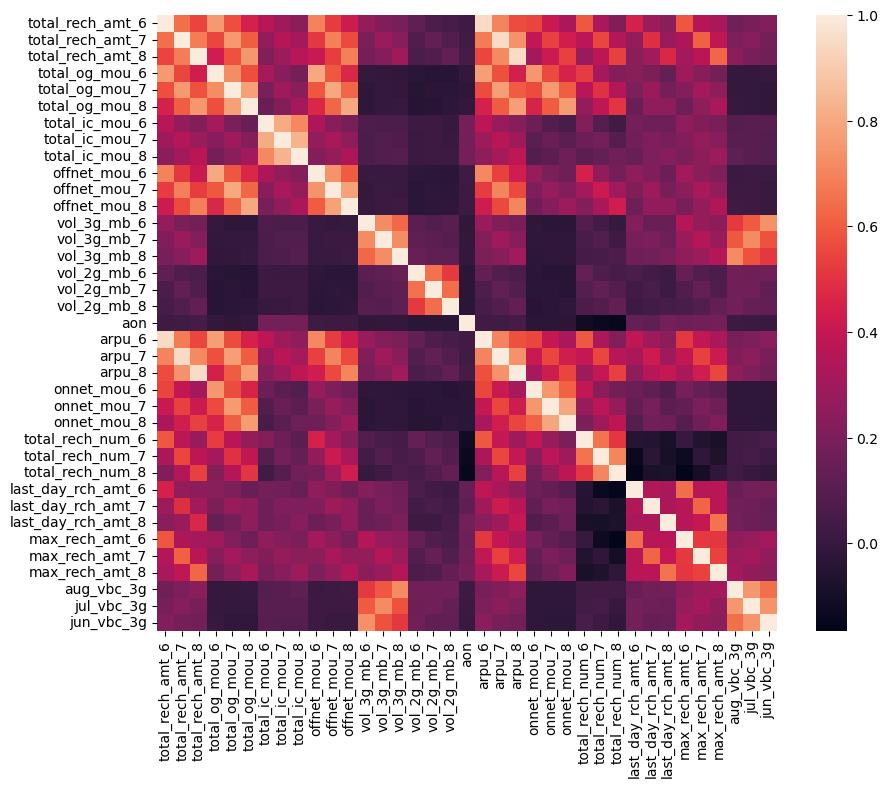

In [111]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(data_telecom, columns=variables).corr())

Following columns can be dropped, as they have collinearity more than 75%
- total_rech_amt and arpu (dropping arpu) 
- onnet_mou and total_og_mou (dropping onnet_mou) 
- offet_mou and total_og_mou (dropping offet_mou) 
- total_ic_mou_6 and total_ic_mou_8 are highly correlated to total_ic_mou_7 and incoming call frequency may not effect the churn probability, hence dropping them

In [112]:
variables = list(set(variables) - set(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8','offnet_mou_6', 'offnet_mou_7','arpu_6', 'arpu_7','arpu_8','offnet_mou_8', "total_ic_mou_6", "total_ic_mou_8"]))

In [113]:
print(len(variables))
data_telecom = data_telecom[variables+target_variable]

26


<Axes: >

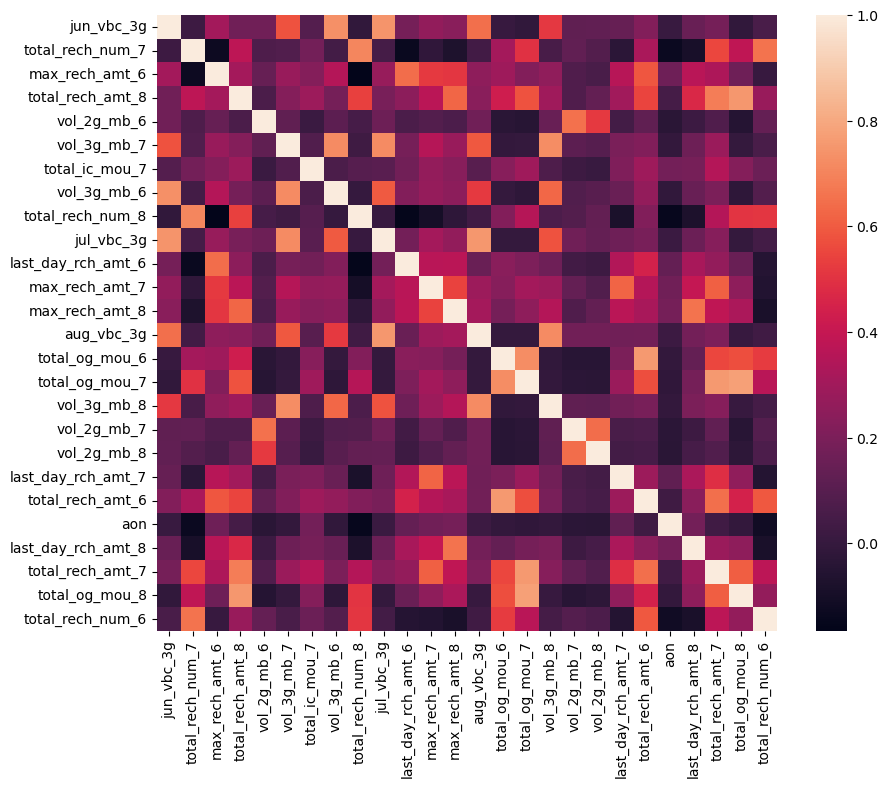

In [114]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(data_telecom, columns=variables).corr())

Lets study trend of recharge across all three months for the people who churned

In [115]:
churned_data = data_telecom[data_telecom[target_variable[0]]==1]
churned_data

,jun_vbc_3g,total_rech_num_7,max_rech_amt_6,total_rech_amt_8,vol_2g_mb_6,vol_3g_mb_7,total_ic_mou_7,vol_3g_mb_6,total_rech_num_8,jul_vbc_3g,last_day_rch_amt_6,max_rech_amt_7,max_rech_amt_8,aug_vbc_3g,total_og_mou_6,total_og_mou_7,vol_3g_mb_8,vol_2g_mb_7,vol_2g_mb_8,last_day_rch_amt_7,total_rech_amt_6,aon,last_day_rch_amt_8,total_rech_amt_7,total_og_mou_8,total_rech_num_6,churn_probability
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.0,3.0,200.00000,150.0,0.0,0.0,0.00,0.00,1.0,0.0,200.000000,0.0,150.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,200.0,2455.0,150.0,0.0,0.00,2.0,1
31,0.0,0.0,104.00000,0.0,0.0,0.0,0.99,0.00,0.0,0.0,104.000000,0.0,0.0,0.0,1250.590000,197.11,0.00,0.0,0.0,0.0,104.0,303.0,0.0,0.0,0.00,1.0,1
33,0.0,3.0,468.79237,252.0,0.0,0.0,0.00,756.47,2.0,0.0,357.291575,0.0,252.0,0.0,0.000000,0.00,74.29,0.0,0.0,0.0,505.0,457.0,252.0,0.0,2.68,1.0,1
41,0.0,10.0,36.00000,0.0,0.0,0.0,27.08,0.00,3.0,0.0,36.000000,30.0,0.0,0.0,39.250000,243.86,0.00,0.0,0.0,0.0,66.0,194.0,0.0,140.0,0.00,2.0,1
55,0.0,7.0,30.00000,120.0,0.0,0.0,43.84,0.00,5.0,0.0,30.000000,36.0,30.0,0.0,108.230000,148.73,0.00,0.0,0.0,20.0,90.0,789.0,30.0,126.0,36.16,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69942,0.0,4.0,0.00000,0.0,0.0,0.0,0.00,0.00,5.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,516.0,0.0,0.0,0.00,1.0,1
69950,0.0,2.0,200.00000,0.0,0.0,0.0,0.00,0.00,4.0,0.0,110.000000,0.0,0.0,0.0,1702.960034,0.00,0.00,0.0,0.0,0.0,1470.0,326.0,0.0,0.0,0.00,14.0,1
69956,0.0,0.0,106.00000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,106.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,106.0,1231.0,0.0,0.0,0.00,1.0,1


<Axes: >

<Figure size 2000x800 with 0 Axes>

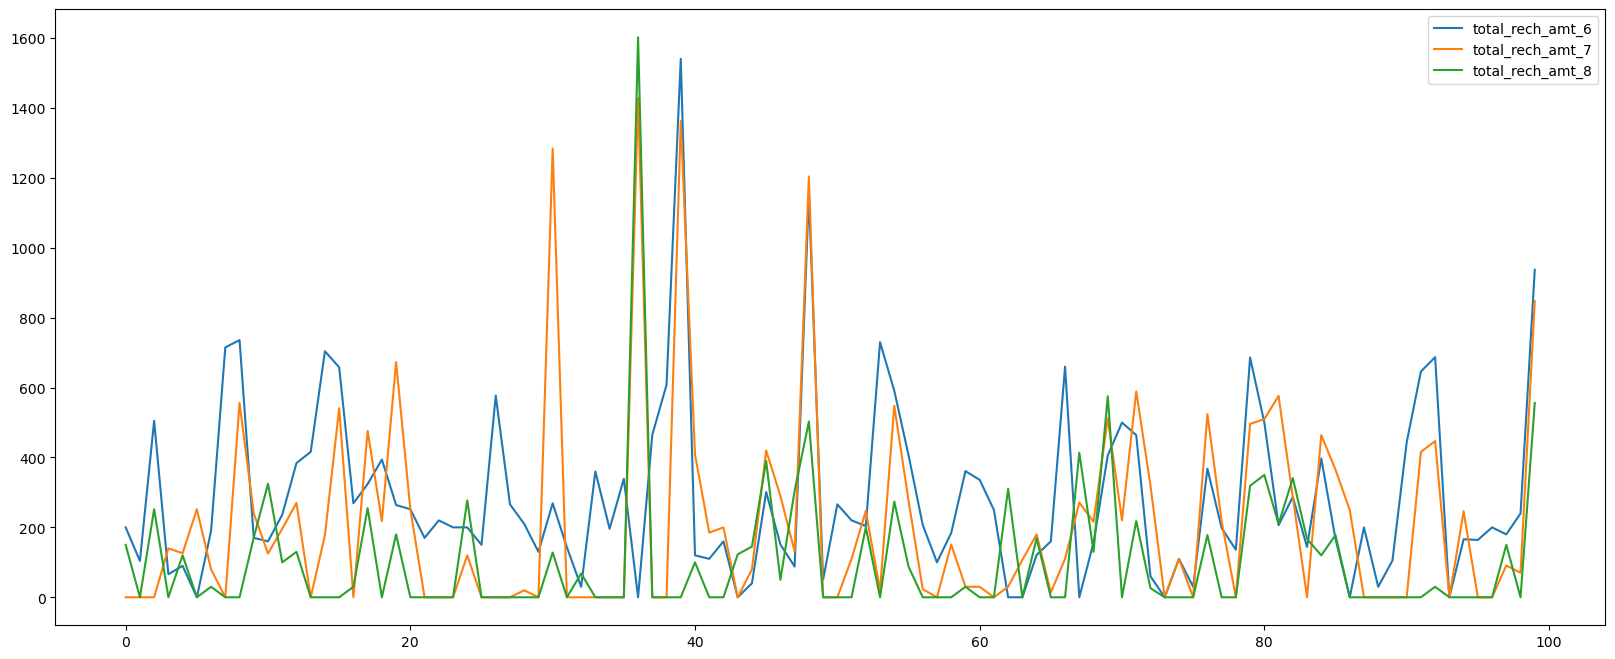

In [116]:
rech_vr = ["total_rech_amt_6",	"total_rech_amt_7",	"total_rech_amt_8"]
plt.figure(figsize=(20,8))
churned_data.reset_index(inplace=True)
# Create a line plot
churned_data[rech_vr][:100].plot(figsize=(20,8))

<Axes: >

<Figure size 2000x800 with 0 Axes>

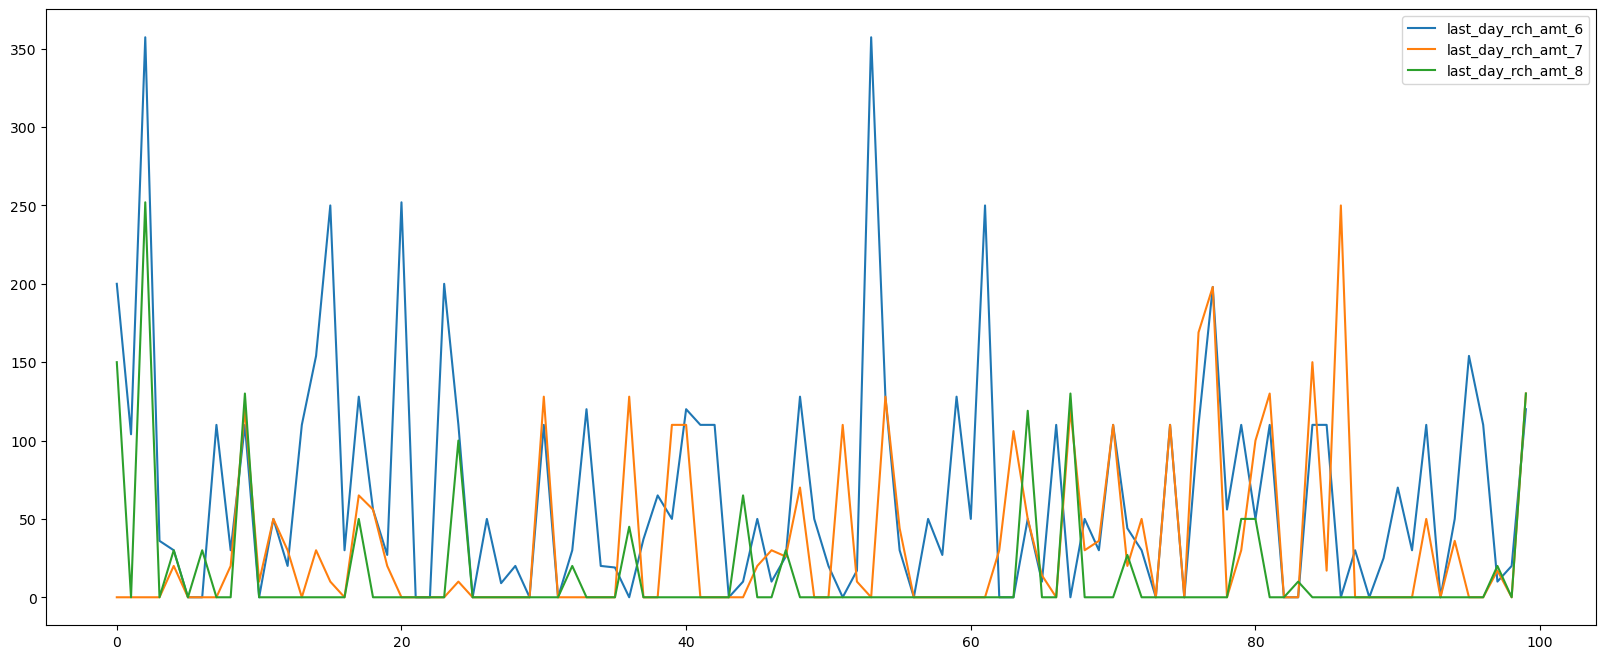

In [117]:
plt.figure(figsize=(20,8))
churned_data.reset_index(inplace=True)
# Create a line plot
churned_data[last_day_rch_amt][:100].plot(figsize=(20,8))

<Axes: >

<Figure size 2000x800 with 0 Axes>

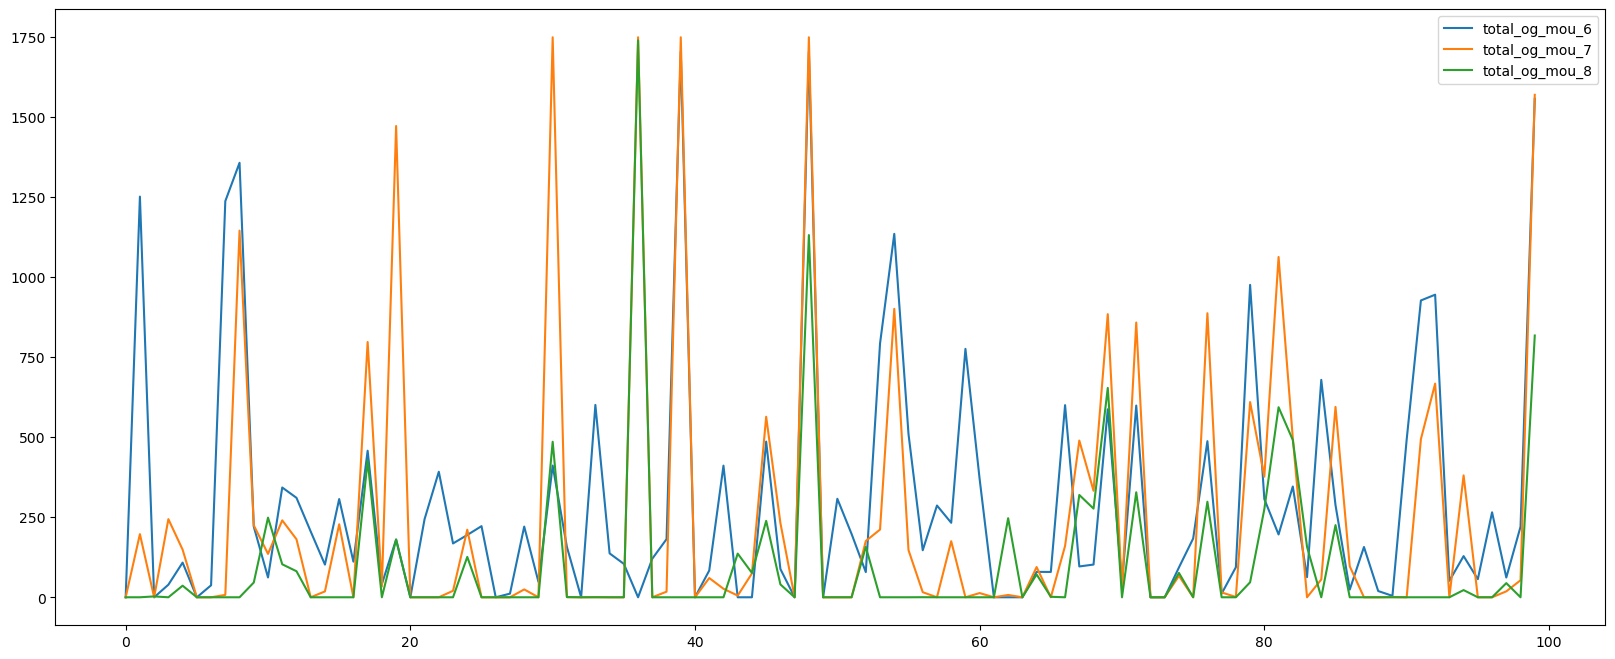

In [118]:
plt.figure(figsize=(20,8))
# Create a line plot
churned_data[total_outgoing_minutes][:100].plot(figsize=(20,8))

As a general observation, people who are likely to churn has less total recharge value in last month, total outgoing calls and last day's recharge amount is very low or almost 0

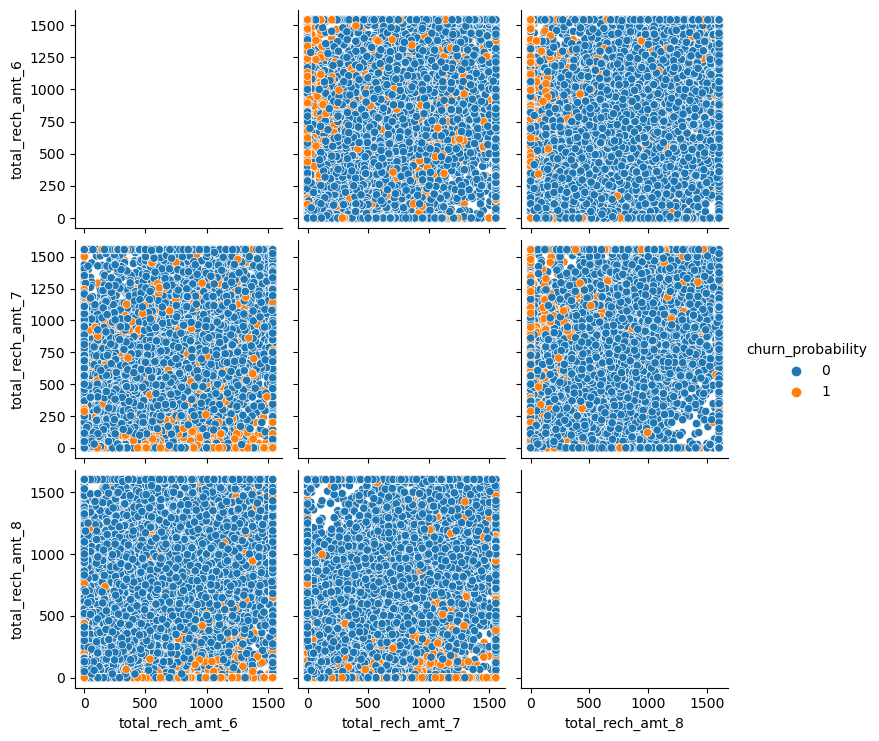

In [119]:
sns.pairplot(data=data_telecom[["total_rech_amt_6",	"total_rech_amt_7",	"total_rech_amt_8",'churn_probability']],hue='churn_probability',diag_kind='None')
plt.show()

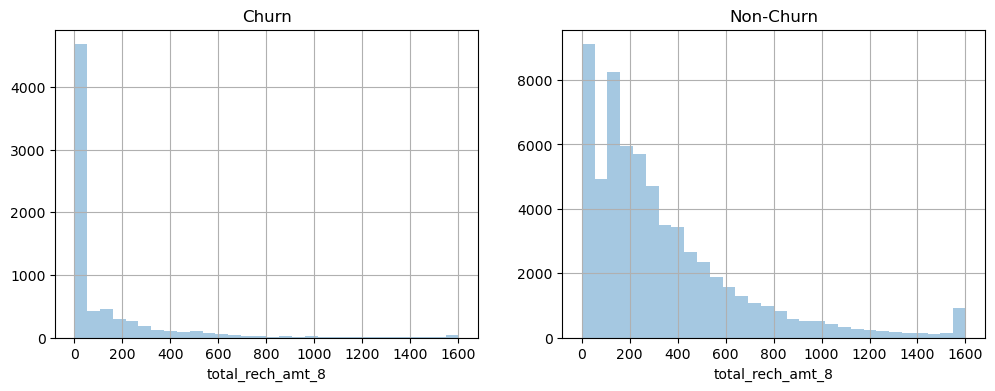

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(data_telecom[data_telecom['churn_probability']==1].total_rech_amt_8, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax.grid()
ax = sns.distplot(data_telecom[data_telecom['churn_probability']==0].total_rech_amt_8, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')
ax.grid()
plt.show()

Lets see if some data can be ignore where recharge amount is not that significant

In [121]:
data_telecom.groupby("churn_probability").mean()

,jun_vbc_3g,total_rech_num_7,max_rech_amt_6,total_rech_amt_8,vol_2g_mb_6,vol_3g_mb_7,total_ic_mou_7,vol_3g_mb_6,total_rech_num_8,jul_vbc_3g,last_day_rch_amt_6,max_rech_amt_7,max_rech_amt_8,aug_vbc_3g,total_og_mou_6,total_og_mou_7,vol_3g_mb_8,vol_2g_mb_7,vol_2g_mb_8,last_day_rch_amt_7,total_rech_amt_6,aon,last_day_rch_amt_8,total_rech_amt_7,total_og_mou_8,total_rech_num_6
churn_probability,,,,,,,,,,,,,,,,,,,,,,,,,,
0,49.134644,7.645854,101.029115,337.241333,42.420918,111.709313,202.396815,103.195442,7.406118,55.752825,60.903855,102.858457,109.954583,60.160030,286.296454,301.793520,121.567005,42.432284,43.174327,58.294851,316.798610,1263.916262,63.813629,321.850365,310.729300,7.315000
1,34.209922,6.225927,93.204820,116.449508,32.948417,53.872354,89.735888,75.385275,3.618162,27.263294,52.577122,71.652070,44.861359,14.410173,324.365917,223.719656,26.751595,24.116211,8.545255,35.675621,335.187425,838.383191,17.934877,235.001853,87.735642,7.772339


##### Target variable analysis

Lets study balance in target variable

In [122]:
round((y['churn_probability'].value_counts()*100 / y.shape[0]),2)

0    89.81
1    10.19
Name: churn_probability, dtype: float64

In [123]:
y.value_counts()

churn_probability
0                    62867
1                     7132
dtype: int64

<Axes: ylabel='Count'>

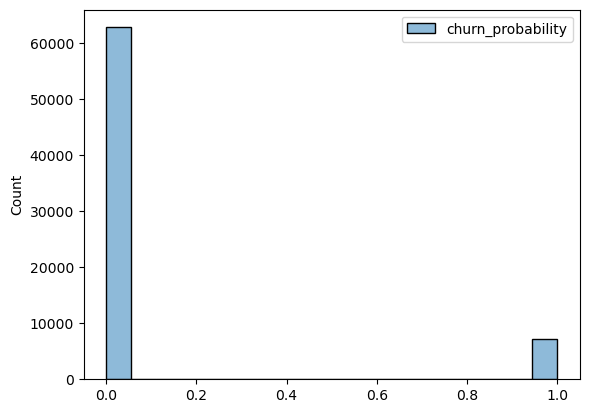

In [124]:
#Distribution for the churn probability
sns.histplot(y)

As data is imbalanced, we need to clean few rows, which may not impact the business and model accuracy as well.

## 4. Data Preparation & Preprocessing

##### 4.a. Train test data split

In [125]:
#Creating X and y variables
X = data_telecom[variables]
y = data_telecom[target_variable]

In [126]:
X.shape, y.shape

((69999, 26), (69999, 1))

Splitting train and test data to avoid any contamination of the test data

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 26), (14000, 26), (55999, 1), (14000, 1))

Check balance of splitted data

In [128]:
y_train.value_counts()
round((y_train['churn_probability'].value_counts()*100 / y_train.shape[0]),2)

0    89.85
1    10.15
Name: churn_probability, dtype: float64

In [129]:
round((y_test['churn_probability'].value_counts()*100 / y_test.shape[0]),2)

0    89.65
1    10.35
Name: churn_probability, dtype: float64

Dealing with data imbalance
We are creating synthetic samples by doing upsampling using SMOTE(Synthetic Minority Oversampling Technique).

In [192]:
# Importing SMOTE
from imblearn.over_sampling import SMOTE
# Instantiate SMOTE
sm = SMOTE(random_state=27)
# Fitting SMOTE to the train set
X_train, y_train = sm.fit_resample(X_train, y_train)
y_train.value_counts()
round((y_train['churn_probability'].value_counts()*100 / y_train.shape[0]),2)

0    50.0
1    50.0
Name: churn_probability, dtype: float64

In [193]:
X_test, y_test = sm.fit_resample(X_test, y_test)
y_test.value_counts()
round((y_test['churn_probability'].value_counts()*100 / y_test.shape[0]),2)

0    50.0
1    50.0
Name: churn_probability, dtype: float64

##### 4.b. Scalability

In [130]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)

<Axes: >

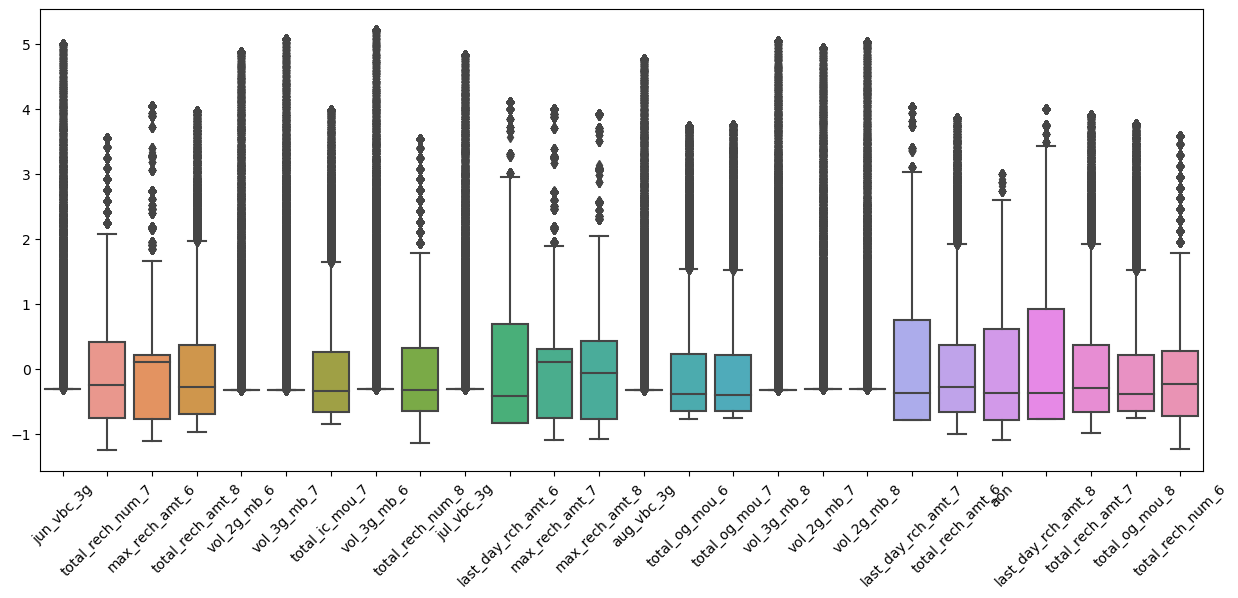

In [131]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_scaled, columns=variables))

##### 4.c. Derived column and Dummy variables

There is no categorical variable, hence we will not need to create dummy variables

In [132]:
data_telecom["total_rech_amt"]= data_telecom["total_rech_amt_6"]+data_telecom["total_rech_amt_7"]+data_telecom["total_rech_amt_8"]

## 5: Feature Engineering using PCA

Let's understand feature importances for raw features as well as components to decide top features for modelling.

# -------------------------------------------Old Code----------------------------

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

<BarContainer object of 26 artists>

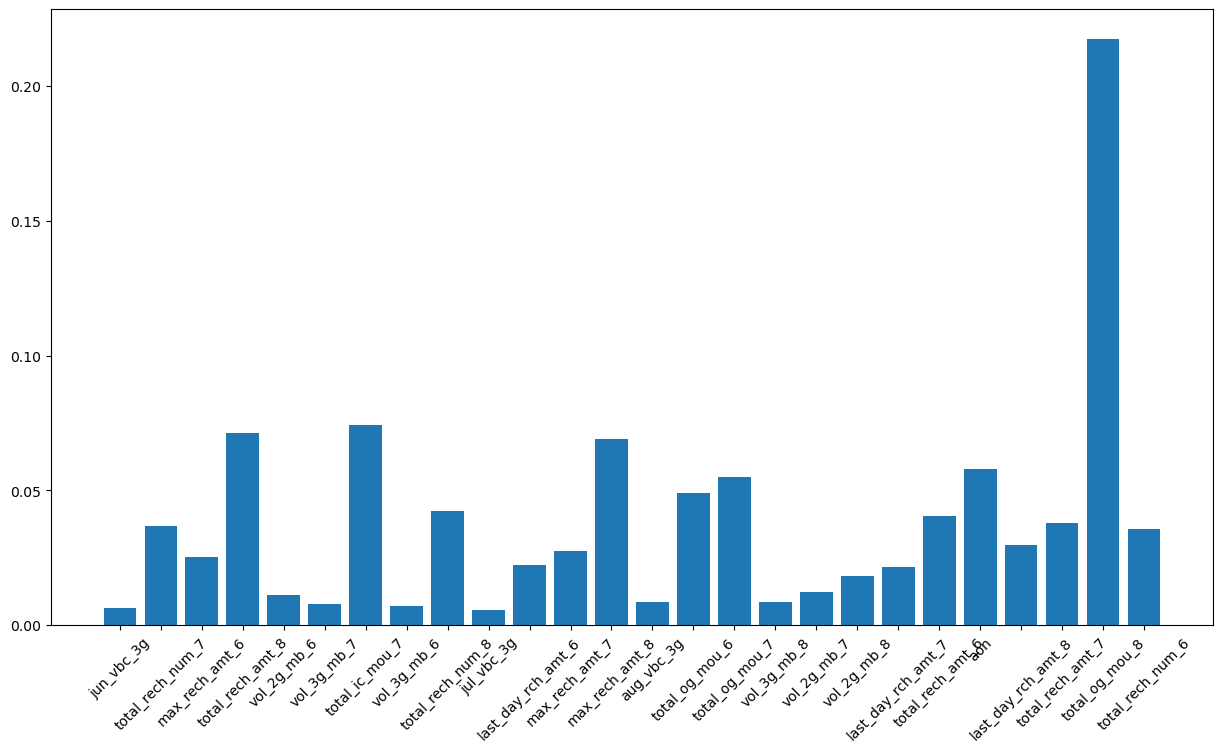

In [137]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame({'col':variables, 'importance':rf.feature_importances_})
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

Using PCA creates components which are a linear combination of the features.


<Axes: >

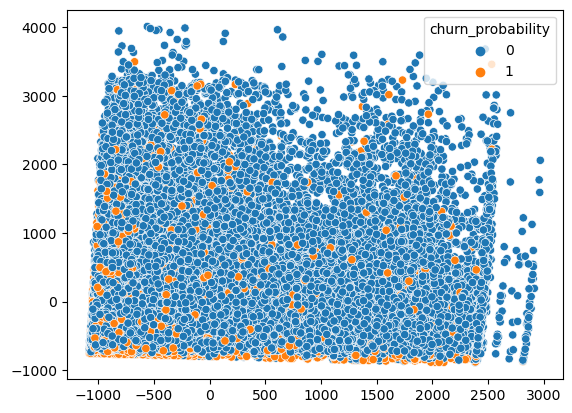

In [141]:
pca = PCA()
pca_components = pca.fit_transform(X_train)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train[target_variable[0]])

<Axes: >

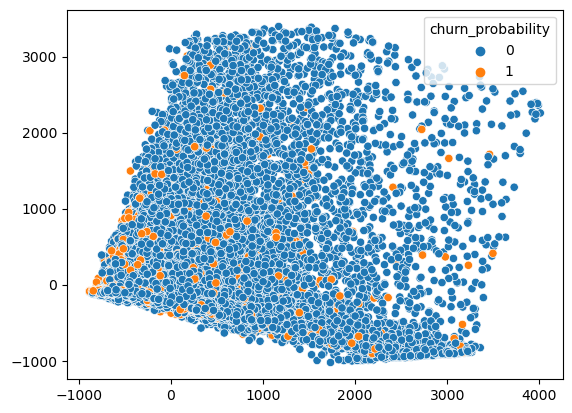

In [142]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train[target_variable[0]])

In [144]:
pca.components_

array([[ 3.52722688e-03, -7.51470140e-04,  1.80563084e-02,
         2.57938956e-02, -5.23603666e-03,  8.87554841e-04,
         4.78818565e-02,  1.76651183e-04, -8.73620248e-04,
         4.49131992e-03,  1.17334966e-02,  1.84291705e-02,
         2.05722812e-02,  5.65765934e-03,  6.79183351e-03,
         4.07528831e-03,  2.13595482e-03, -4.61233913e-03,
        -4.93716039e-03,  1.04914056e-02,  1.96126874e-02,
         9.97157087e-01,  1.63137642e-02,  2.20237474e-02,
         6.30498189e-03, -6.23939709e-04],
       [ 4.46594156e-02,  3.91199218e-03,  4.98316427e-02,
         3.51457418e-01,  7.52820130e-03,  1.19165598e-01,
         1.09283198e-01,  1.03216554e-01,  3.55303990e-03,
         5.26846882e-02,  3.18404601e-02,  5.68138969e-02,
         5.82694369e-02,  5.25652021e-02,  4.03182309e-01,
         4.57607299e-01,  1.20091529e-01,  7.91144636e-03,
         7.41456989e-03,  3.70012121e-02,  3.37408854e-01,
        -4.18714403e-02,  3.42357319e-02,  3.69387542e-01,
         4.25

Looking at the explained variance ratio for each component

In [145]:
pca.explained_variance_ratio_

array([4.11107184e-01, 2.45413194e-01, 1.43398204e-01, 4.37864268e-02,
       2.38237673e-02, 2.25584300e-02, 2.03475279e-02, 1.77673276e-02,
       1.43778888e-02, 1.27518049e-02, 1.01098077e-02, 7.02302869e-03,
       6.16331616e-03, 5.22813440e-03, 3.52294002e-03, 2.63429237e-03,
       2.36370648e-03, 1.91315214e-03, 1.55653089e-03, 1.29787644e-03,
       1.26543329e-03, 8.27716083e-04, 7.41950461e-04, 1.42261902e-05,
       3.77531500e-06, 2.35790717e-06])

Making a scree plot for the explained variance

In [146]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

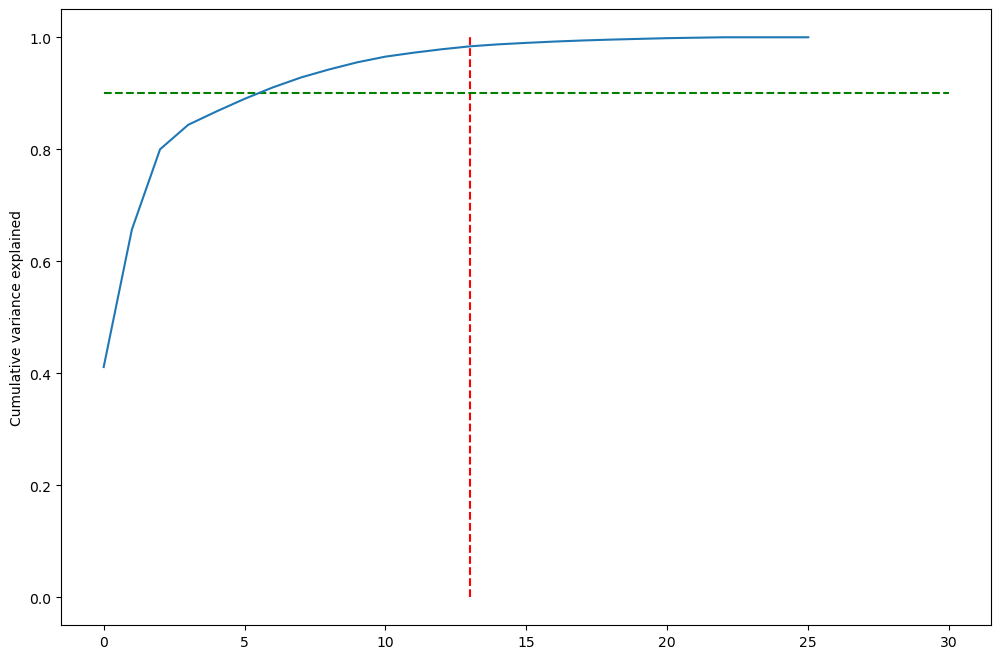

In [156]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=13, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.9, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [158]:
pca_by_variance=PCA(0.9)
pca_components_df = pca_by_variance.fit_transform(X_train)
pca_components_df.shape

(55999, 7)

### Applying logistic regression on the data on our Principal components

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [160]:
learner_pca = LogisticRegression()

In [166]:
model_pca = learner_pca.fit(X_train, y_train)

In [167]:
pred_probs_test = model_pca.predict_proba(X_test)

In [176]:
y_pred = model_pca.predict(X_test)

In [168]:
pred_probs_test.shape

(14000, 2)

In [175]:
pred_probs_test

array([[0.99847338, 0.00152662],
       [0.744327  , 0.255673  ],
       [0.93241825, 0.06758175],
       ...,
       [0.97733376, 0.02266624],
       [0.90833926, 0.09166074],
       [0.99628713, 0.00371287]])

In [170]:
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test[:,1]))

'0.84'

We see an overall AUC score of 0.84 which is good .


In [178]:
from sklearn.metrics import accuracy_score


score =accuracy_score(y_test,y_pred)
score

0.901

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [179]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=7)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [183]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [184]:
pipe.fit(X_train[variables], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=7)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [185]:
train_score = pipe.score(X_train[variables], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9034982767549421


In [186]:
test_score = pipe.score(X_test[variables], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8993571428571429


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [ ]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50022,   271],
       [ 5322,   384]])

In [ ]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12507,    67],
       [ 1333,    93]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [ ]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.58125

In [ ]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.06521739130434782

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [ ]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 16)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.